# Topic Modeling in a single notebook

This page contains all the code necessary to train a topic model using Gibbs sampling for standard LDA. There are no non-standard dependencies beyond cython. Some users have had problems on Windows loading cython, I'm not able to fix these.

In [1]:
import numpy as np
%load_ext cython

import re, sys, random, math
from collections import Counter
from timeit import default_timer as timer
from IPython.display import display, clear_output, Markdown, Latex

from matplotlib import pyplot

word_pattern = re.compile("\w[\w\-\']*\w|\w")

In [2]:
num_topics = 30
doc_smoothing = 0.5
word_smoothing = 0.01

In [3]:
%%cython

from cython.view cimport array as cvarray
import numpy as np
import random
from timeit import default_timer as timer

class Document:
    
    def __init__(self, long[:] doc_tokens, long[:] doc_topics, long[:] topic_changes, long[:] doc_topic_counts):
        self.doc_tokens = doc_tokens
        self.doc_topics = doc_topics
        self.topic_changes = topic_changes
        self.doc_topic_counts = doc_topic_counts

cdef class TopicModel:
    
    cdef long[:] topic_totals
    cdef long[:,:] word_topics
    cdef int num_topics
    cdef int vocab_size
    
    cdef double[:] topic_probs
    cdef double[:] topic_normalizers
    cdef float doc_smoothing
    cdef float word_smoothing
    cdef float smoothing_times_vocab_size
    
    documents = []
    vocabulary = []
    
    def __init__(self, num_topics, vocabulary, doc_smoothing, word_smoothing):
        self.num_topics = num_topics
        self.vocabulary.extend(vocabulary)
        self.vocab_size = len(vocabulary)
        
        self.doc_smoothing = doc_smoothing
        self.word_smoothing = word_smoothing
        self.smoothing_times_vocab_size = word_smoothing * self.vocab_size
        
        self.topic_totals = np.zeros(num_topics, dtype=int)
        self.word_topics = np.zeros((self.vocab_size, num_topics), dtype=int)
    
    def clear_documents(self):
        self.documents.clear()
    
    def add_document(self, doc):
        cdef int word_id, topic
        
        self.documents.append(doc)
        
        for i in range(len(doc.doc_tokens)):
            word_id = doc.doc_tokens[i]
            topic = random.randrange(self.num_topics)
            doc.doc_topics[i] = topic
            
            self.word_topics[word_id,topic] += 1
            self.topic_totals[topic] += 1
            doc.doc_topic_counts[topic] += 1
            
    def sample(self, iterations):
        cdef int old_topic, new_topic, word_id, topic, i, doc_length
        cdef double sampling_sum = 0
        cdef double sample
        cdef long[:] word_topic_counts
        
        cdef long[:] doc_tokens
        cdef long[:] doc_topics
        cdef long[:] doc_topic_counts
        cdef long[:] topic_changes
        
        cdef double[:] uniform_variates
        cdef double[:] topic_probs = np.zeros(self.num_topics, dtype=float)
        cdef double[:] topic_normalizers = np.zeros(self.num_topics, dtype=float)
        
        for topic in range(self.num_topics):
            topic_normalizers[topic] = 1.0 / (self.topic_totals[topic] + self.smoothing_times_vocab_size)
        
        for iteration in range(iterations):
            for document in self.documents:
                doc_tokens = document.doc_tokens
                doc_topics = document.doc_topics
                doc_topic_counts = document.doc_topic_counts
                topic_changes = document.topic_changes
                
                doc_length = len(document.doc_tokens)
                uniform_variates = np.random.random_sample(doc_length)
                
                for i in range(doc_length):
                    word_id = doc_tokens[i]
                    old_topic = doc_topics[i]
                    word_topic_counts = self.word_topics[word_id,:]
        
                    ## erase the effect of this token
                    word_topic_counts[old_topic] -= 1
                    self.topic_totals[old_topic] -= 1
                    doc_topic_counts[old_topic] -= 1
        
                    topic_normalizers[old_topic] = 1.0 / (self.topic_totals[old_topic] + self.smoothing_times_vocab_size)
        
                    ###
                    ### SAMPLING DISTRIBUTION
                    ###
        
                    sampling_sum = 0.0
                    for topic in range(self.num_topics):
                        topic_probs[topic] = (doc_topic_counts[topic] + self.doc_smoothing) * (word_topic_counts[topic] + self.word_smoothing) * topic_normalizers[topic]
                        sampling_sum += topic_probs[topic]

                    sample = uniform_variates[i] * sampling_sum
        
                    new_topic = 0
                    while sample > topic_probs[new_topic]:
                        sample -= topic_probs[new_topic]
                        new_topic += 1
            
                    ## add the effect of this token back in
                    word_topic_counts[new_topic] += 1
                    self.topic_totals[new_topic] += 1
                    doc_topic_counts[new_topic] += 1
                    topic_normalizers[new_topic] = 1.0 / (self.topic_totals[new_topic] + self.smoothing_times_vocab_size)

                    doc_topics[i] = new_topic
        
                    if new_topic != old_topic:
                        #pass
                        topic_changes[i] += 1

    def topic_words(self, int topic, n_words=12):
        sorted_words = sorted(zip(self.word_topics[:,topic], self.vocabulary), reverse=True)
        return " ".join([w for x, w in sorted_words[:n_words]])

    def print_all_topics(self):
        for topic in range(self.num_topics):
            print(topic, self.topic_words(topic))

In [4]:
## Read the stoplist file

stoplist = set()
with open("stoplists/en.txt", encoding="utf-8") as stop_reader:
    for line in stop_reader:
        line = line.rstrip()
        stoplist.add(line)


## Read the documents file
        
word_counts = Counter()
documents = []

for line in open("sample_data/stats_10k.txt", encoding="utf-8"):
    #line = line.lower()
    
    tokens = word_pattern.findall(line)
    
    ## remove stopwords, short words, and upper-cased words
    tokens = [w for w in tokens if not w in stoplist and len(w) >= 3 and not w[0].isupper()]
    word_counts.update(tokens)
    
    doc_topic_counts = np.zeros(num_topics, dtype=int)
    
    documents.append({ "original": line, "token_strings": tokens, "topic_counts": doc_topic_counts })

## Now that we're done reading from disk, we can count the total
##  number of words.
vocabulary = list(word_counts.keys())
word_ids = { w: i for (i, w) in enumerate(vocabulary) }

## With the vocabulary, go back and create arrays of numeric word IDs
for document in documents:
    tokens = document["token_strings"]
    doc_topic_counts = document["topic_counts"]
    
    doc_tokens = np.ndarray(len(tokens), dtype=int)
    doc_topics = np.ndarray(len(tokens), dtype=int)
    topic_changes = np.zeros(len(tokens), dtype=int)
    
    for i, w in enumerate(tokens):
        doc_tokens[i] = word_ids[w]
        ## topics will be initialized by the model
    
    document["doc_tokens"] = doc_tokens
    document["doc_topics"] = doc_topics
    document["topic_changes"] = topic_changes

### This cell actually runs the model

This may take some time to run. It will print "Done!" at the end.

I've made some changes since Monday that will let you re-run this cell without errors.

In [5]:
model = TopicModel(num_topics, vocabulary, doc_smoothing, word_smoothing)

## `documents` seems to be a class variable, not an object variable
model.clear_documents()

for document in documents:
    document["topic_changes"].fill(0)
    document["topic_counts"].fill(0)
    c_doc = Document(document["doc_tokens"], document["doc_topics"], document["topic_changes"], document["topic_counts"])
    model.add_document(c_doc)

sampling_dist = np.zeros(num_topics, dtype=float)

doc_topic_probs = np.zeros((len(model.documents), num_topics))
word_topic_probs = np.zeros((len(vocabulary), num_topics))

# Initial burn-in iterations
for i in range(10): # using 500 iterations for faster stoplist curation
    start = timer()
    model.sample(50)
    elapsed_time = timer() - start
    
    display(Markdown("### Iteration {}, {:.2f} seconds per iteration".format((i+1) * 50, elapsed_time / 50)))
    
    table_markdown = "### Iteration {}, {:.2f} seconds per iteration\n".format((i+1) * 50, elapsed_time / 50)
    table_markdown += "|Topic | Most likely words (descending)|\n"
    table_markdown += "|----|:----|\n"
    for topic in range(num_topics):
        table_markdown += "|{}|{}|\n".format(topic, model.topic_words(topic, 12))
    
    clear_output()
    display(Markdown(table_markdown))
        
# Saved samples
for i in range(5):
    model.sample(10)
    
    for doc_id, doc in enumerate(model.documents):
        for word_id, topic in zip(doc.doc_tokens, doc.doc_topics):
            doc_topic_probs[doc_id,topic] += 1
            word_topic_probs[word_id,topic] += 1

            
print("Done!")
            
# Normalize
doc_row_sums = doc_topic_probs.sum(axis=1)
doc_topic_probs /= doc_row_sums[:,np.newaxis]

word_col_sums = word_topic_probs.sum(axis=0)
word_topic_probs /= word_col_sums[np.newaxis,:]

topic_top_words = []
for topic in range(num_topics):
    sorted_words = sorted(zip(word_topic_probs[:,topic], vocabulary), reverse=True)
    topic_top_words.append(" ".join([w for x, w in sorted_words[:12]]))

### Iteration 500, 0.14 seconds per iteration
|Topic | Most likely words (descending)|
|----|:----|
|0|you your will want then have what need can may could use|
|1|amp text end begin first can second equation all must align will|
|2|analysis paper study methods studies statistical control used their survival was results|
|3|data plot points line set like with can graph have would how|
|4|time series data with change over have some like would noise process|
|5|regression variables variable model linear with logistic independent coefficients dependent one continuous|
|6|scale scores with have score items some would they response which like|
|7|interval confidence distance intervals use can you clustering method cluster using which|
|8|would you with factor one your not analysis all factors effect other|
|9|frac alpha theta beta hat right left sigma sum_ log lambda sqrt|
|10|distribution normal random distributions with function distributed density has probability not can|
|11|but question what have like not would know how about there don't|
|12|mean standard values value error deviation variance median average sum residuals zero|
|13|sample size population estimate samples error with large small sampling variance have|
|14|also with package has available good but packages look nice very here|
|15|probability value with which true probabilities given can about have prior then|
|16|was have out been has but had how what just with some|
|17|not one which only does can because even make more when but|
|18|test hypothesis tests not null difference two testing significant statistic whether use|
|19|between correlation two not case measure can with variables same relationship when|
|20|can use using function code with package like but example functions get|
|21|problem point algorithm function points which solution space some can there method|
|22|matrix each have you table with first values column can vector which|
|23|but not they will you more it's much work because good very|
|24|number each have one times 100 will people all with 000 two|
|25|effect group each with groups have effects random different treatment between time|
|26|set class use selection features data classification using can with training feature|
|27|statistics good statistical with about some book more learning theory methods course|
|28|data analysis have some there would can different other more many etc|
|29|model data models fit parameters likelihood can with using parameter function use|


Done!


/Users/mimno/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


### Representing a document as a mixture of topics

At the end of the training process I'm saving multiple samples and averaging over them to get better estimates of the probability of words in topics and the probability of topics in words.

For convenience, I created an array `topic_top_words` that contains the top 12 most probable words in this averaged matrix.

In [11]:
documents[0]["original"]

' How should I elicit prior distributions from experts when fitting a Bayesian model? \n'

Here are the most probable topics in this document:

In [7]:
sorted(zip(doc_topic_probs[0,:], topic_top_words), reverse=True)

[(0.35,
  'model data models fit parameters likelihood with you can parameter using function'),
 (0.15,
  'statistics good statistical with book some methods about learning more theory many'),
 (0.15,
  'distribution normal random distributions with function distributed can has density not probability'),
 (0.075,
  'probability value prior true probabilities which given with number can about then'),
 (0.05,
  'problem algorithm point solution function which points with some space can method'),
 (0.05,
  'data analysis have some would there more can different such other many'),
 (0.025, 'you your will want then can have need may what could use'),
 (0.025,
  'with scores scale score items have response they some item also more'),
 (0.025,
  'sample size population estimate samples error large sampling variance with small have'),
 (0.025,
  'regression variables variable model with linear logistic independent coefficients dependent continuous have'),
 (0.025, "but not they more will much 

### This cell shows the prevalence of each topic from the beginning of the work to the end.


0 you your will want then have


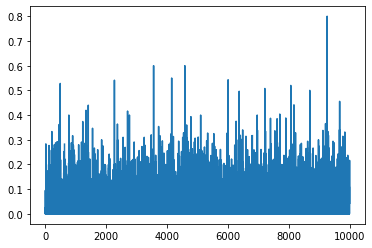

1 amp text end begin first can


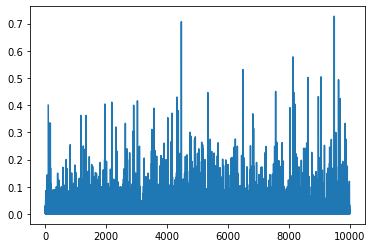

2 paper analysis study used studies their


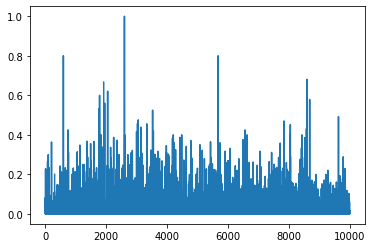

3 data plot points like line with


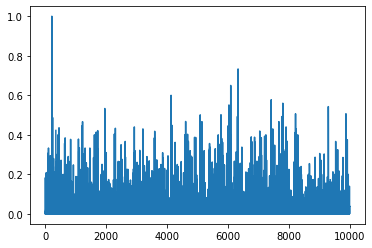

4 time series data change over have


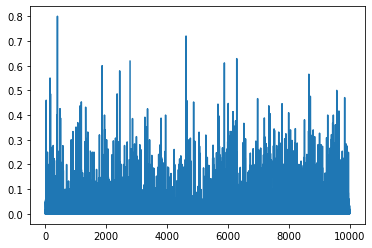

5 regression variables variable model with linear


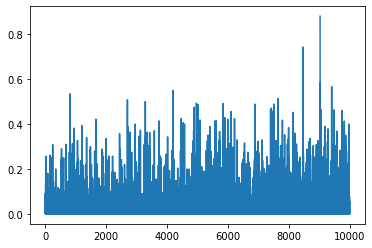

6 with scores scale score items have


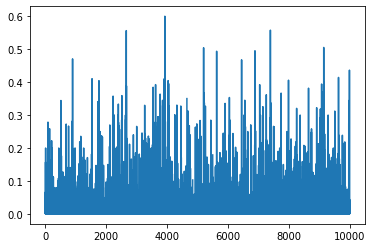

7 interval confidence distance can intervals method


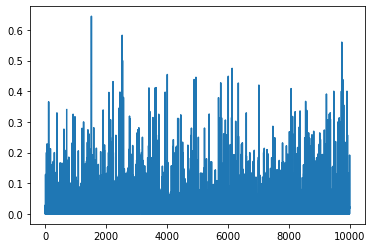

8 would you factor one with your


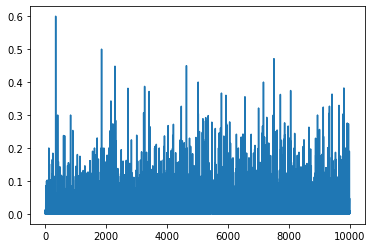

9 frac alpha right beta theta hat


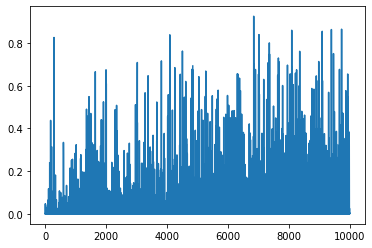

10 distribution normal random distributions with distributed


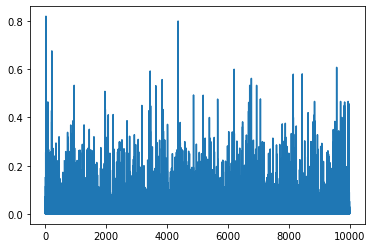

11 question but what not like how


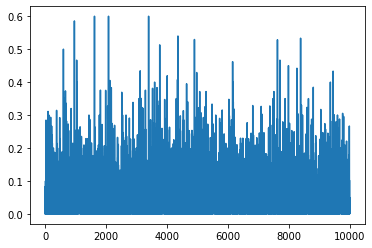

12 mean standard values value error deviation


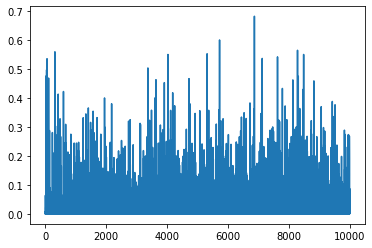

13 sample size population estimate samples error


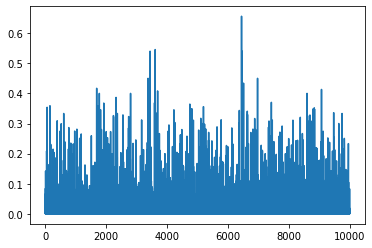

14 also package has with available here


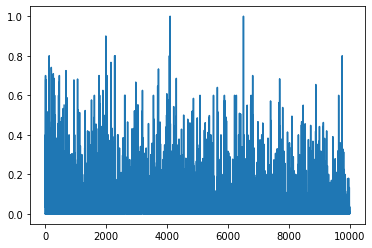

15 probability value which prior true probabilities


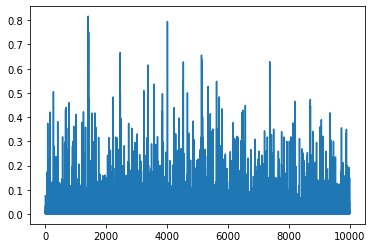

16 was have been what get had


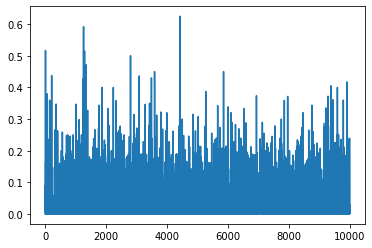

17 not one but which does only


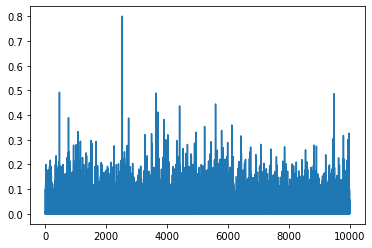

18 test hypothesis tests null not difference


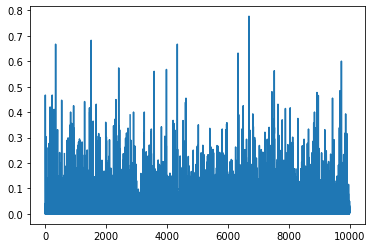

19 between correlation two can not same


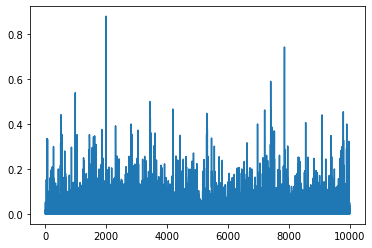

20 use function can using with code


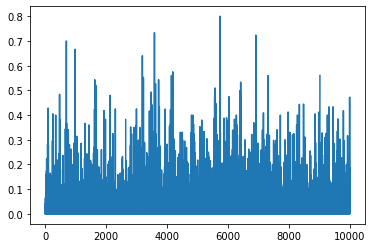

21 problem algorithm point solution which function


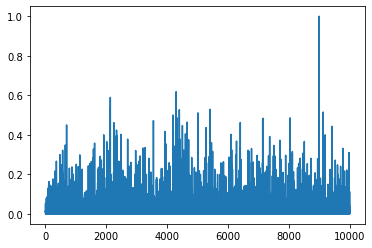

22 matrix have each with you table


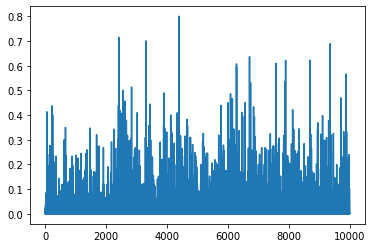

23 they but not more will because


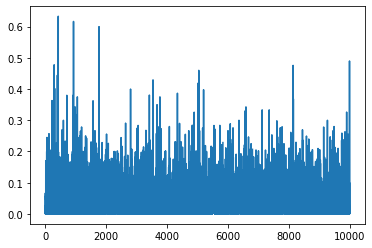

24 number each one times 100 have


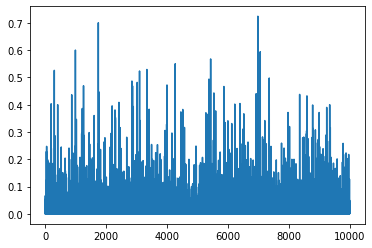

25 effect each group have groups effects


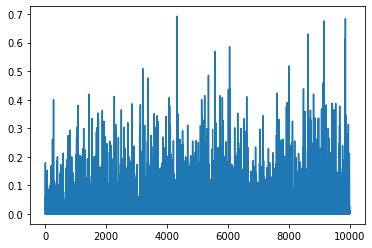

26 set class use data selection features


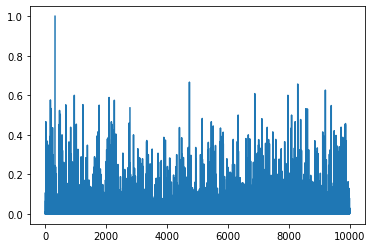

27 statistics good with statistical some book


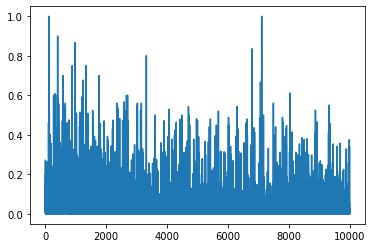

28 data analysis some have would different


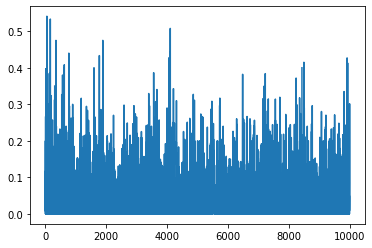

29 model data models fit parameters likelihood


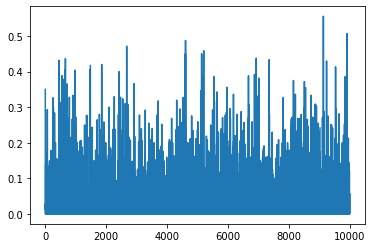

In [8]:
for topic in range(num_topics):
    print(topic, model.topic_words(topic, n_words=6))
    pyplot.plot(doc_topic_probs[:,topic])
    pyplot.show()

### This cell prints the documents with the largest proportion of a specified topic.


In [9]:
def top_docs(topic, n_docs=10):
    for doc_id in np.argsort(-doc_topic_probs[:,topic])[:n_docs]:
        print("{} {:.1f}% | {}".format(doc_id, 100 * doc_topic_probs[doc_id,topic], documents[doc_id]["original"]))

In [10]:
top_docs(11)

2077 60.0% |  Another from XKCD : Mentioned here and here . 

3394 60.0% |  See this SO question: 

1616 60.0% |  Does this help? 

956 58.6% |  Introductory, advanced, and even obscure, please. Mostly to test myself. I like to make sure I know what the heck I'm talking about :) Thanks 

4358 54.0% |  I know what you're thinking, this is a duplicate of " What are the differences between Factor Analysis and Principal Component Analysis ", but it isn't really. That other question deals with Confirmatory Factor Analysis. Either way, I would like to know what the difference is :) Thanks! 

8387 53.3% |  I would like to clarify how the Granger causality can/should be used in practice, and how to interpret the statistical significance given by the test. Also, I would like to fill this table with things like "we don't know" or if we know something, what do we know (It will for sure not be causality, but maybe something else?). 

4900 52.9% |  I'm still not sure what you're trying to do and I 